In [1]:
import cv2, numpy as np, os, random, uuid
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# ---------- 基础退化函数 ----------
def add_gaussian_noise(img, var=22):
    noise = np.random.normal(0, var ** 0.5, img.shape).astype(np.int16)
    return np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

def add_uniform_noise(img, low=-18, high=18):
    noise = np.random.uniform(low, high, img.shape).astype(np.int16)
    return np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

def add_poisson_noise(img):
    vals = 2 ** np.ceil(np.log2(len(np.unique(img))))
    return np.clip(np.random.poisson(img * vals) / vals, 0, 255).astype(np.uint8)

def add_motion_blur(img, k=9):
    kernel = np.zeros((k, k), np.float32)
    kernel[random.randint(0, k-1), :] = 1.0
    kernel /= kernel.sum()
    return cv2.filter2D(img, -1, kernel)

def add_jpeg_artifact(img, quality=85):
    enc = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, quality])[1]
    return cv2.imdecode(enc, cv2.IMREAD_UNCHANGED)


In [3]:
# ---------- 其余轻变换 ----------
def random_rotation(img, a_range=(-20, 20)):
    a = random.uniform(*a_range); h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), a, 1.0)
    return cv2.warpAffine(img, M, (w,h), borderMode=cv2.BORDER_REPLICATE)

def add_glare(img, alpha=0.25, max_size=0.25):
    h,w = img.shape[:2]
    r = int(min(h,w)*random.uniform(0.05,max_size))
    cx,cy = random.randint(r,w-r), random.randint(r,h-r)
    mask = np.zeros_like(img, np.float32)
    cv2.circle(mask,(cx,cy),r,(255,255,255),-1)
    mask = cv2.GaussianBlur(mask,(0,0),r/2)
    return np.clip(img.astype(np.float32)*(1-alpha)+mask*alpha,0,255).astype(np.uint8)

In [4]:
# ---------- 退化映射表 ----------
noise_dict = {
    "gaussian":  lambda img: add_gaussian_noise(img, var=random.uniform(15,20)),
    "uniform":   lambda img: add_uniform_noise(img, low=-27, high=27),
    "poisson":   add_poisson_noise,
    "motion":    lambda img: add_motion_blur(img, k=random.choice([4,5,7])),
    "jpeg":      lambda img: add_jpeg_artifact(img, quality=random.randint(56,75))
}

In [5]:
def augment_three(img):
    choices = random.sample(list(noise_dict.keys()), 1)      # 保证不同
    outputs = []
    for ntype in choices:
        out = noise_dict[ntype](img)                         # 单一噪声
        out = random_rotation(out)
        out = add_glare(out)
        out = random_rotation(out)
        out = add_glare(out)  
        outputs.append((out, ntype))
    return outputs                                           # [(img, "gaussian"), ...]


In [6]:
# ---------- 批量处理 ----------
def augment_folder_recursive(src_root, dst_root):
    src_root, dst_root = Path(src_root), Path(dst_root)

    for img_path in src_root.rglob("*.*"):  # 遍历所有图片文件
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]: continue
        img = cv2.imread(str(img_path))
        if img is None: continue

        # 计算目标路径（保持相对结构）
        relative_path = img_path.relative_to(src_root)
        dst_subdir = dst_root / relative_path.parent
        dst_subdir.mkdir(parents=True, exist_ok=True)

        # 生成增强图
        aug_list = augment_three(img)
        for idx, (aug_img, ntype) in enumerate(aug_list, 1):
            out_name = f"{img_path.stem}({idx}).jpg"
            cv2.imwrite(str(dst_subdir / out_name), aug_img)

In [7]:
def augment_one_image(src_path, dst_dir):
    src_path, dst_dir = Path(src_path), Path(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)  # 确保输出目录存在

    img = cv2.imread(str(src_path))
    if img is None:
        print(f"❌ 无法读取图像: {src_path}")
        return

    aug_list = augment_three(img)  # 返回3张增强图 [(img, 'gaussian'), ...]

    for idx, (aug_img, ntype) in enumerate(aug_list, 3):
        out_name = f"{src_path.stem}({idx}).jpg"
        out_path = dst_dir / out_name
        cv2.imwrite(str(out_path), aug_img)
        print(f"✅ 保存: {out_path} | 噪声类型: {ntype}")

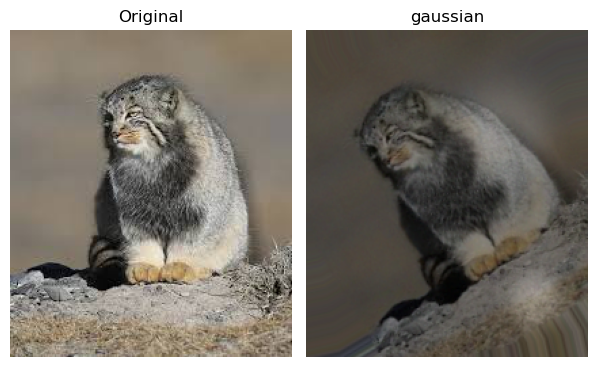

In [8]:
# ---------- Demo 单张显示 ----------
if __name__ == "__main__":
    demo_path = "/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/mix_dataset/validation/Pallas cats/Pallas cats_33.jpg"      # ← 换成你的图
    img  = cv2.imread(demo_path)
    aug3 = augment_three(img)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    for i,(aug,ntype) in enumerate(aug3,2):
        plt.subplot(1,4,i); plt.imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
        plt.title(f"{ntype}"); plt.axis("off")
    plt.tight_layout(); plt.show()

    # --- 批量调用示例 ---
    augment_folder_recursive("/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/mix_dataset", "/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/blurred_dataset(2)")

In [ ]:
# augment_one_image("/Users/ruiyuhan/Desktop/222.jpg","./data")

✅ 保存: data/222(3).jpg | 噪声类型: motion
